# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [12]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [13]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import IBMBackend
from qiskit_aer import AerSimulator
from qiskit.providers.backend import BackendV1, BackendV2


## Step 0: **Define** the (classical) problem

In [14]:
prob = generate_problem(n=32, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")


A: [[ 4.91559363e-01  3.80252637e-02  4.89503029e-17 ... -4.64254065e-02
  -1.54916584e-16  1.92127476e-02]
 [ 3.80252637e-02  3.59822713e-01 -4.92284297e-17 ... -1.40175867e-16
  -7.45379613e-17  1.76192887e-03]
 [ 4.89503029e-17 -4.92284297e-17  3.98740210e-01 ...  2.50870303e-16
   2.36692786e-02 -3.90768043e-17]
 ...
 [-4.64254065e-02 -1.40175867e-16  2.50870303e-16 ...  5.58894231e-01
   1.02420165e-16  5.61815977e-17]
 [-1.54916584e-16 -7.45379613e-17  2.36692786e-02 ...  1.02420165e-16
   5.10919463e-01  5.11057850e-18]
 [ 1.92127476e-02  1.76192887e-03 -3.90768043e-17 ...  5.61815977e-17
   5.11057850e-18  3.46029955e-01]]

b: [ 0.09016874 -0.10265272  0.16694162  0.07241834  0.44183625 -0.1876702
  0.10258693 -0.22995711 -0.12528504  0.12094732 -0.47073364 -0.15374502
 -0.17163946 -0.03537842  0.00556788 -0.16075951 -0.15641436 -0.06005417
  0.01854396 -0.21442375 -0.00347768 -0.11934269 -0.04675718 -0.08489916
  0.19291747  0.22804872 -0.20216868 -0.20627538  0.04830592  0.13

## Step 1: **Map** problem to quantum circuits and operators

In [15]:
hhl = HHL(
    state_prep = StatePrep(method='default'), 
    readout = 'measure_x',
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = math.log2(len(b)),
    t0 = 2 * np.pi)

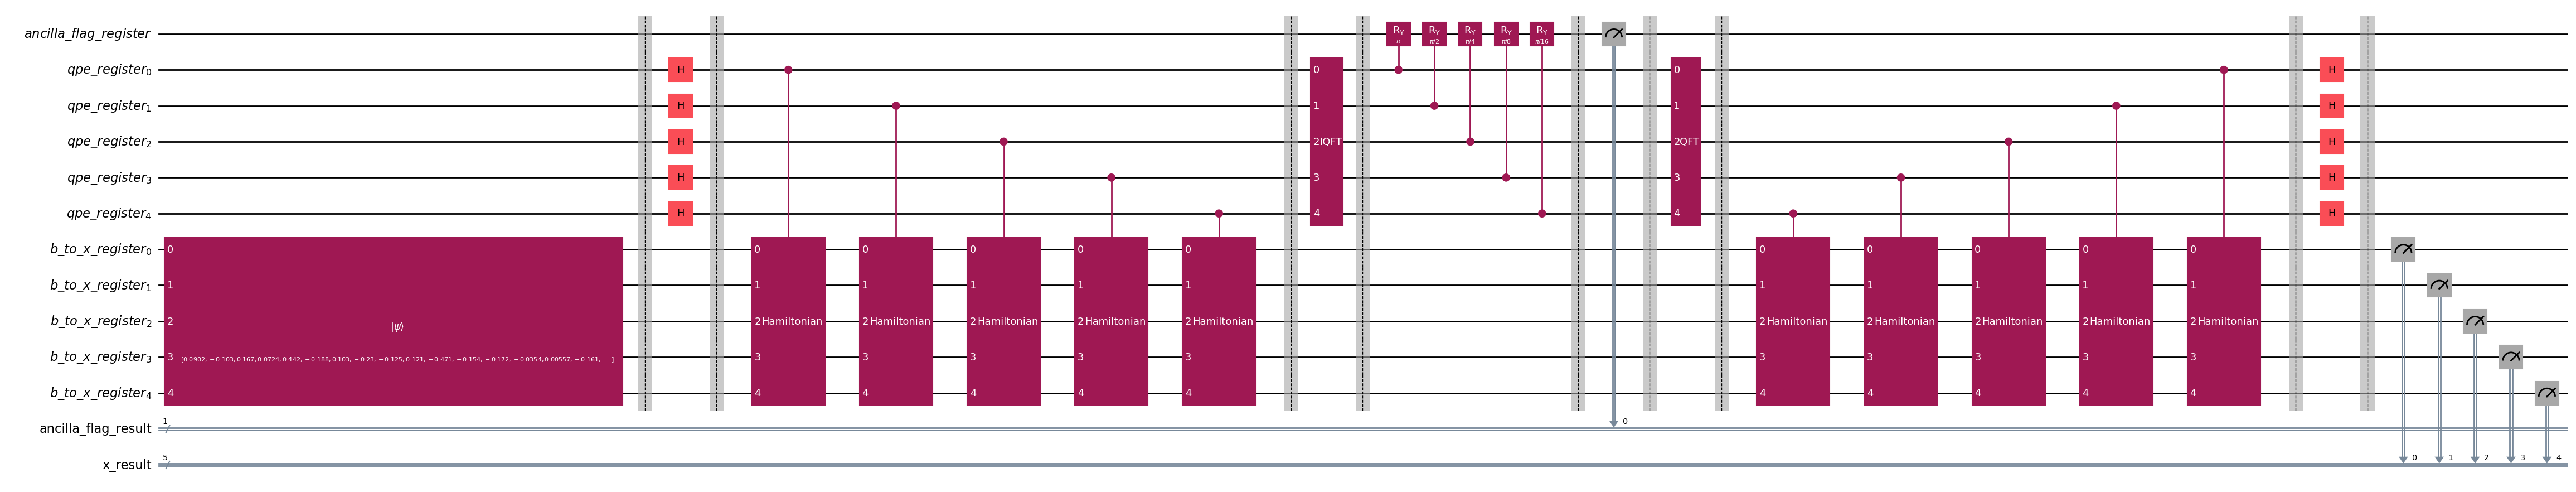

In [16]:
hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [17]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [18]:
# Define a backend

service = QiskitRuntimeService(name="QLSAs")

#backend = service.backend("ibm_boston")

# backend = service.least_busy(
#     operational=True,
#     min_num_qubits=hhl_circuit.num_qubits
# )
# print("Backend: ", backend)

backend = AerSimulator()

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        9051
2q-size:         9065
Operator counts: OrderedDict([('cu', 6800), ('ccx', 4440), ('cp', 2260), ('h', 20), ('p', 10), ('barrier', 9), ('measure', 6), ('cry', 5), ('initialize', 1)])


## Step 3: **Execute** on target hardware

In [19]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend, 
    shots = 250
    )

>>> Job ID: 9db535f1-170e-4bfa-85fe-334a80645828
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE


## Step 4: **Process** result to obtain classical solution

In [20]:
processor = Post_Processor()
solution = processor.process(result, A, b)
solution

array([ 0.12309149, -0.12309149,  0.12309149, -0.        ,  0.44381268,
       -0.        ,  0.12309149, -0.        , -0.        ,  0.        ,
       -0.30151134, -0.        , -0.30151134,  0.        ,  0.17407766,
       -0.27524094, -0.32566947, -0.        ,  0.        , -0.17407766,
        0.12309149, -0.        , -0.        , -0.        ,  0.17407766,
        0.17407766, -0.21320072, -0.40824829, -0.        ,  0.        ,
       -0.17407766,  0.        ])

## Wrapping steps 1-4 together in a solver:

In [21]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    shots = 250,
    optimization_level = 3,
    executer = executer,
    post_processor = processor)

hhl_solution = hhl_solver.solve(A, b)
print(f"Solution: {hhl_solution}")

>>> Job ID: 32267344-b94a-4eb0-ac12-cf901b0cda6d
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
Solution: [ 0.         -0.          0.17277369 -0.          0.36650833 -0.
  0.         -0.         -0.          0.24433889 -0.36650833 -0.17277369
 -0.36650833  0.12216944  0.12216944 -0.27317918 -0.21160368 -0.
  0.         -0.21160368  0.         -0.12216944 -0.12216944 -0.
  0.12216944  0.         -0.12216944 -0.4404882  -0.17277369  0.
 -0.          0.        ]


## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: 29ea7479-60ec-48c6-8e5e-2651c30fc0b9
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.6591, error: 0.8005, alpha: 1.1770

IR Iteration: 1
>>> Job ID: 61661824-ffd3-4a9e-b056-2a4c430355d7
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.6359, error: 0.6780, alpha: 0.6124

IR Iteration: 2
>>> Job ID: e2b0ac26-b09a-4b44-bc15-6eeafc7a334e
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.4900, error: 0.5547, alpha: 1.0573

IR Iteration: 3
>>> Job ID: a32e5f46-8abc-4107-9cb6-d97308283ca3
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.3858, error: 0.4026, alpha: 1.5330

IR Iteration: 4
>>> Job ID: 92fede5e-be58-42ba-a2e7-226500dd3bc3
>>> Job Status: JobStatus.RUNNING...
>>> Job Status: JobStatus.DONE
  residual: 0.3372, error: 0.3422, alpha: 0.9410

IR Iteration: 5
>>> Job ID: 5299a9d3-9b71-430b-b5a5-2b38cc0d30cc
>>> Job Status: JobS

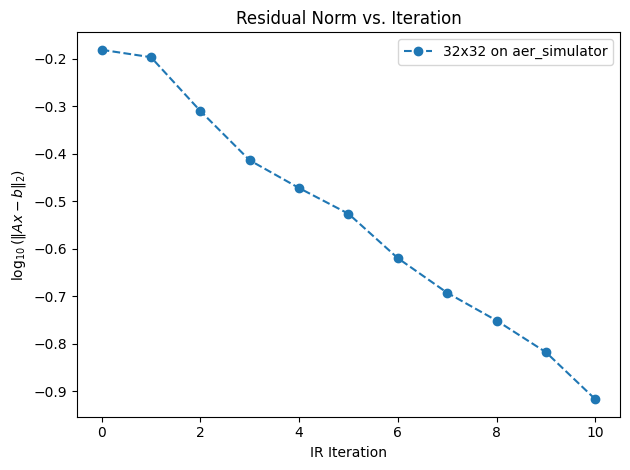

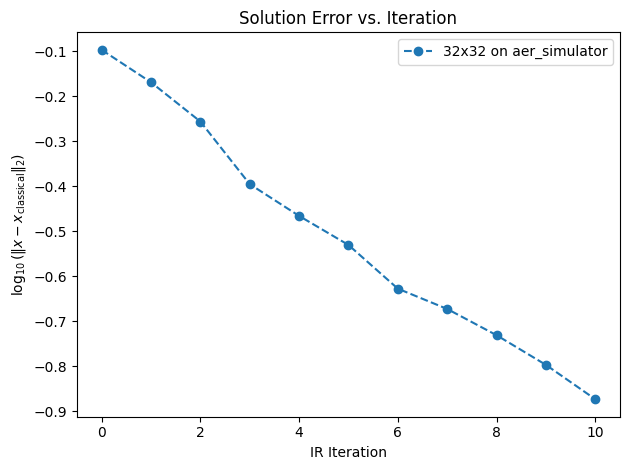

In [22]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)

refined_solution = refiner.refine(precision = 1e-6, max_iter = 10, plot=True)